### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [5]:
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [6]:
import matplotlib.pyplot as plt
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



670752


In [15]:
import os, json

animal = 0
TEST_DATA = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, animal)[:, :, :, :, 40:80]
best_test = np.zeros((TEST_DATA.shape[0], TEST_DATA.shape[1], TEST_DATA.shape[3], TEST_DATA.shape[4]))
for i in range(TEST_DATA.shape[0]):
    for j in range(TEST_DATA.shape[1]):
        best_sf = np.argmax(jnp.nanmean(TEST_DATA[i, j, :, :, :], axis=(1, 2))).astype('int')
        best_test[i, j, :, :] = TEST_DATA[i, j, best_sf, :, :]
TEST_RESPONSE = jnp.nanmean(best_test, axis=-1)  # Shape N x C x K
# Animal = 0, SF = 0 and during response
good_trials = ~jnp.isnan(TEST_RESPONSE).any(axis=(0, 1))   # shape (K,)

TEST_RESPONSE = TEST_RESPONSE[:, :, good_trials]
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

# good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
# TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)

def load_best_hp(animal, out_dir):
    """Return (best_hp: dict, best_ll: float) for this animal."""
    json_path = os.path.join(out_dir, f"animal_{animal:02d}.json")
    with open(json_path, "r") as f:
        data = json.load(f)
    return data["best_hp"], float(data["best_ll"])
best_hp, best_ll = load_best_hp(animal, "hp_runs/sated")


0 123.18403625488281
l_gp_a   = 2.926680088043213
g_gp_a   = 0.0002235178544651717
b_gp_a   = 0.07540135830640793
l_wp_a   = 2.111997365951538
g_wp_a   = 0.018773483112454414
b_wp_a   = 0.1437336802482605
p        = 0


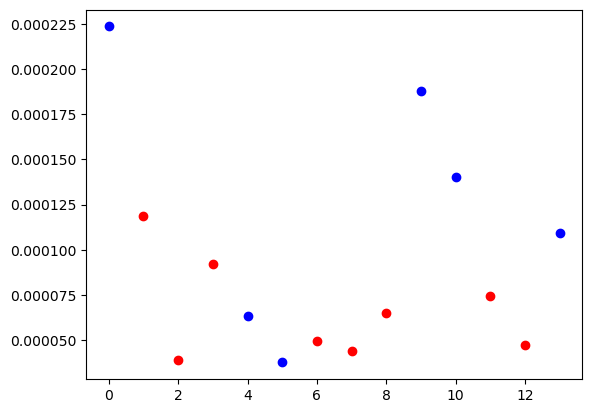

In [8]:
print(animal, best_ll)
for k, v in best_hp.items():
    print(f"{k:8s} = {v}")

for animal in FOOD_RESTRICTED_SATED:
    best_hp, best_ll = load_best_hp(animal, "hp_runs/sated")
    gamma_gp = best_hp['g_gp_a']
    plt.scatter(animal, gamma_gp, color = 'red')
for animal in CONTROL_SATED:
    best_hp, best_ll = load_best_hp(animal, "hp_runs/sated")
    gamma_gp = best_hp['g_gp_a']
    plt.scatter(animal, gamma_gp, color = 'blue')


In [16]:
def hp_internal_to_user(hp_int: dict) -> dict:
    """Convert evaluator/random_search dict -> your preferred schema."""
    return {
        "sigma_m": float(hp_int["l_gp_a"]),
        "gamma_gp": float(hp_int["g_gp_a"]),
        "beta_gp": float(hp_int["b_gp_a"]),
        "sigma_c": float(hp_int["l_wp_a"]),
        "gamma_wp": float(hp_int["g_wp_a"]),
        "beta_wp": float(hp_int["b_wp_a"]),
        "p": int(hp_int["p"]),
    }
hyperparams = hp_internal_to_user(best_hp)

In [6]:
old_hyperparams = {
    'sigma_m':2.4886496,
    'gamma_gp': 0.00016234,
    'beta_gp': 0.24385944,
    'sigma_c': 0.28382865,
    'gamma_wp':0.00044405,
    'beta_wp':1.0398238,
    'p': 0,
}

In [17]:
# Initialise Kernel and Model
print(hyperparams['gamma_gp'])
hyperparams['gamma_gp'] =1e-6 # ensure no latent white-noise in μ

periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_m']))
periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_c']))

0.0002235178544651717


In [18]:
# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=periodic_kernel_gp,N=N)
# wp = models.WishartProcess(kernel =periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
wp = models.WishartLRDProcess(kernel=periodic_kernel_wp,
                              P=hyperparams['p'],V=1e-1*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)

Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [19]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution



joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,TEST_RESPONSE,n_iter = 3000,key=key)
joint.update_params(varfam.posterior)
posterior = models.NormalGaussianWishartPosterior(joint, varfam, X_CONDITIONS)

/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/3000 [00:00<?, ?it/s]/home/scastedo/miniforge3/envs/wishart/lib/python3.13/site-packages/jax/_src/linear_util.py:370: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = _fun(*args, **kwargs)
100%|██████████| 3000/3000 [00:18<00:00, 162.52it/s, init loss: 182408448.3835, avg. loss [2851-3000]: -3754.1736]


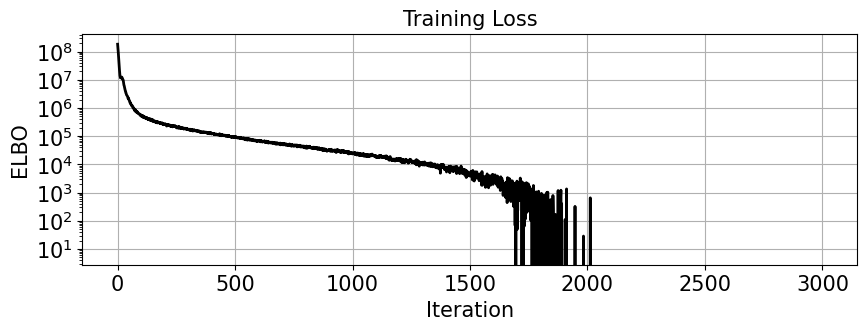

In [20]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


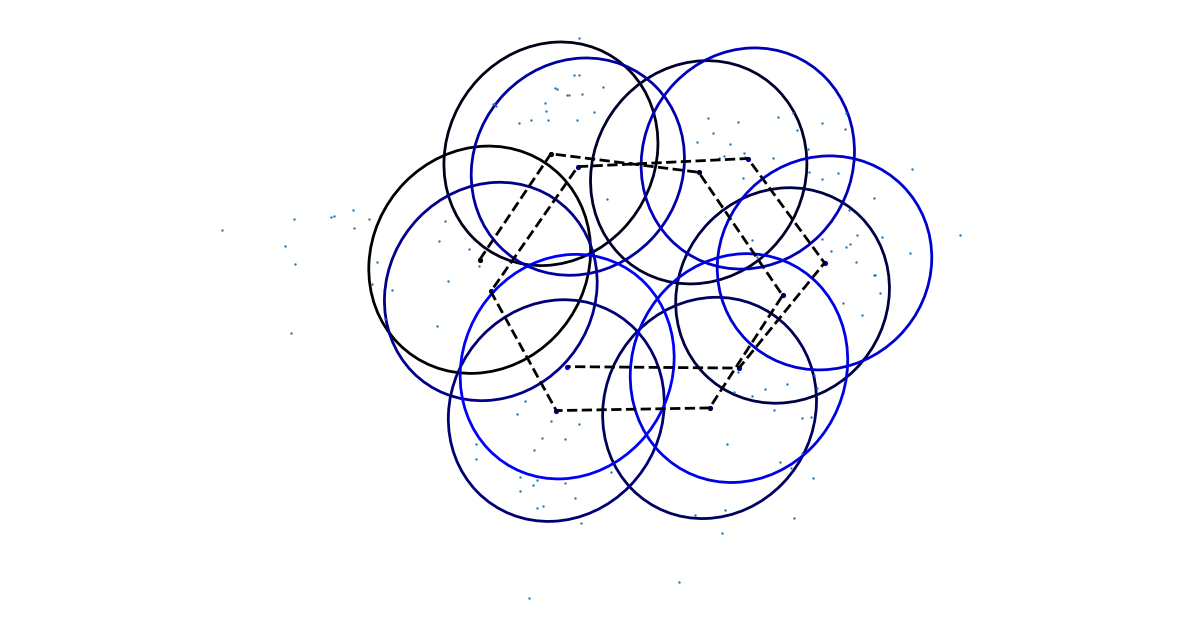

In [21]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


# Compare to Empirical

(12, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


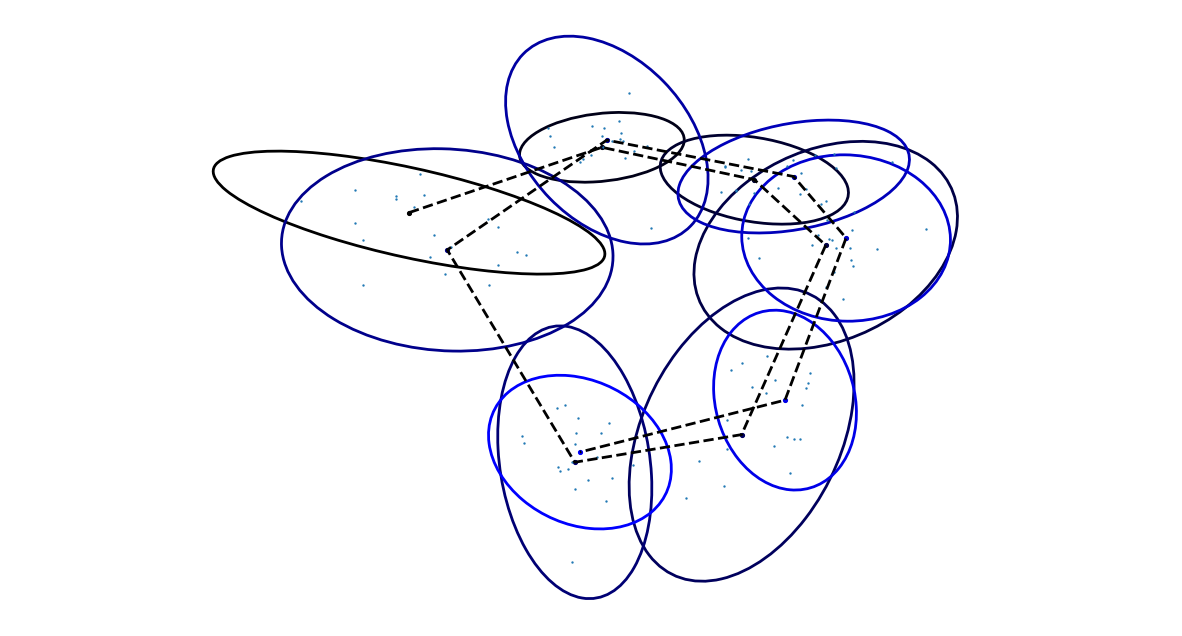

In [48]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)



# Test Unseen conditions 

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


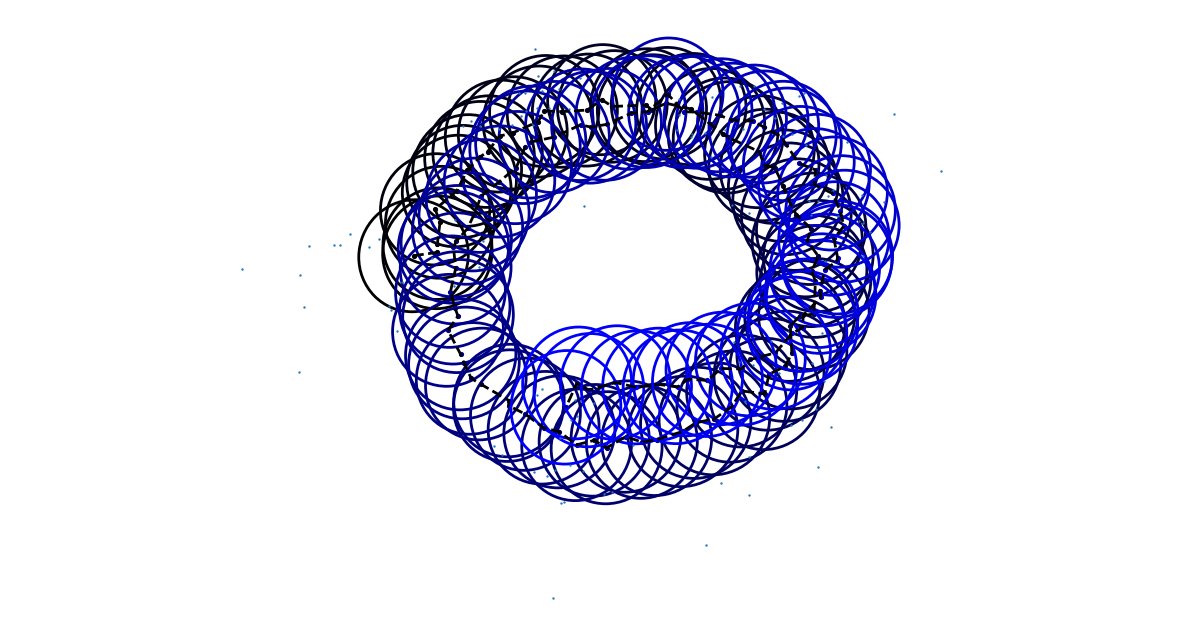

In [25]:
with numpyro.handlers.seed(rng_seed=1):
    X_TEST_CONDITIONS = jnp.linspace(0, C-1, 120)
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(X_TEST_CONDITIONS)

    visualizations.visualize_pc(
        mu_test_hat[:,None],sigma_test_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
    )


In [37]:
import jax, jax.numpy as jnp
import numpy as np
from numpyro import distributions as dist

# ---- data wrangling ----
def split_trials_per_condition(TEST_RESPONSE, train_k=13):
    """
    Split trials within each condition: first 'train_k' trials for training, rest for test.
    TEST_RESPONSE: (N, C, K)
    Returns:
        Y_train: (Ktr, C, N)
        Y_test : (Kte, C, N)
    """
    N, C, K = TEST_RESPONSE.shape
    assert train_k < K
    Y = np.transpose(np.asarray(TEST_RESPONSE), (2,1,0))  # (K, C, N)
    return Y[:train_k], Y[train_k:],  # (Ktr, C, N), (Kte, C, N)

def split_by_conditions(TEST_RESPONSE, X_CONDITIONS, train_frac=0.8, rng=0):
    """
    Withhold a subset of *conditions* entirely.
    Returns train/test splits and index masks.
    """
    N, C, K = TEST_RESPONSE.shape
    rs = np.random.RandomState(rng)
    all_idx = np.arange(C)
    train_C = int(np.round(train_frac * C))
    train_idx = np.sort(rs.choice(all_idx, size=train_C, replace=False))
    test_idx  = np.setdiff1d(all_idx, train_idx)

    Y = np.transpose(np.asarray(TEST_RESPONSE), (2,1,0))  # (K, C, N)
    Y_train = Y[:, train_idx, :]  # (K, Ctr, N)
    Y_test  = Y[:, test_idx,  :]  # (K, Cte, N)
    X_train = np.asarray(X_CONDITIONS)[train_idx]
    X_test  = np.asarray(X_CONDITIONS)[test_idx]
    return (Y_train, X_train, train_idx), (Y_test, X_test, test_idx)

# ---- likelihood and scoring ----
def mvn_logpdf(y, mu, Sigma):
    """
    y: (..., N)
    mu: (..., N)
    Sigma: (..., N, N)  (must be PSD/PD)
    returns: (...,) log p(y | N(mu, Sigma))
    """
    return dist.MultivariateNormal(loc=mu, covariance_matrix=Sigma).log_prob(y)

def posterior_predictive_loglik(posterior, X_eval, Y_eval, S=32, seed=0):
    """
    Monte-Carlo estimate of posterior predictive log-likelihood on held-out trials
    (Supp. B.4; draw S samples of (mu, Sigma) and average their likelihoods). :contentReference[oaicite:2]{index=2}
    X_eval: (C_eval, d_x)
    Y_eval: (K_eval, C_eval, N)
    """
    key = jax.random.PRNGKey(seed)
    # sample S times from the posterior at the evaluation conditions (interpolates if unseen)
    mus, sigmas = [], []
    for s in range(S):
        with numpyro.handlers.seed(rng_seed=int(jax.random.randint(key, (), 0, 2**31))):
            mu_s, Sigma_s, _ = posterior.sample(X_eval)  # shapes: (C_eval, N), (C_eval, N, N)
        mus.append(mu_s)
        sigmas.append(Sigma_s)

    # stack: (S, C, N), (S, C, N, N)
    MU = jnp.stack(mus, axis=0)
    SIG = jnp.stack(sigmas, axis=0)

    # broadcast Y_eval (K, C, N) over S samples -> (S, K, C, N)
    K_eval, C_eval, N = Y_eval.shape
    Y = jnp.broadcast_to(jnp.asarray(Y_eval)[None, ...], (MU.shape[0], K_eval, C_eval, N))  # (S,K,C,N)
    MUbc = MU[:, None, :, :]        # (S,1,C,N)
    SIGbc = SIG[:, None, :, :, :]    # (S,1,C,N,N)

    # log p(y | mu, Sigma) per (S,K,C)
    logp = jax.vmap(  # over S
            jax.vmap(  # over K
                jax.vmap(lambda y, mu, Sg: mvn_logpdf(y, mu, Sg), in_axes=(0,0,0)),  # over C
                in_axes=(0,0,0)
            ), in_axes=(0,0,0)
        )(Y, MUbc, SIGbc)

    # log mean over S samples (log-sum-exp trick)
    logp = jax.nn.logsumexp(logp, axis=0) - jnp.log(logp.shape[0])  # (K,C)
    # return averages for convenience
    return {
        "per_trial_per_cond": np.array(logp),    # shape (K_eval, C_eval)
        "mean_over_trials": float(jnp.mean(logp)),
        "mean_over_all": float(jnp.mean(logp)),
    }


In [42]:
y_full = TEST_RESPONSE  # (K, C, N)
x_full = jnp.arange(C)[:, None]
period = C

# 1) split trials within each condition
data = utils.split_data(
    x=x_full,
    y=y_full,
    train_trial_prop=0.8,
    train_condition_prop=0.8,
    seed=2,
)
x_tr, y_tr, _, _, x_te, y_te, *_ = data
x_tr, x_te = x_tr.reshape(-1), x_te.reshape(-1)

# 2) fit your model *only* on training trials
gp = models.GaussianProcess(kernel=periodic_kernel_gp, N=N)
wp = models.WishartLRDProcess(kernel=periodic_kernel_wp, P=hyperparams['p'], V=1e-1*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)
joint = models.JointGaussianWishartProcess(gp, wp, likelihood)

varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key  = jax.random.PRNGKey(2)

# Your joint expects X (conditions) and y as (K, C, N)
varfam.infer(adam, X_CONDITIONS, y_tr, n_iter=1000, key=key)
joint.update_params(varfam.posterior)
posterior_tr = models.NormalGaussianWishartPosterior(joint, varfam, X_CONDITIONS)

# 3) evaluate log-lik on held-out trials (same conditions)
scores = posterior_predictive_loglik(posterior_tr, np.asarray(X_CONDITIONS), y_te["x_test"], S=32, seed=0)
print("Trial-holdout mean log-lik (higher is better):", scores["mean_over_all"])

# 4) visualize ellipses + held-out trials (as in paper)
with numpyro.handlers.seed(rng_seed=2):
    mu_hat, sigma_hat, _ = posterior_tr.sample(np.asarray(X_CONDITIONS))  # (C,N), (C,N,N)
visualizations.visualize_pc(
    mu_hat[:,None], sigma_hat, pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)
# Optionally overplot your test trials in the top-2 PCs for a couple of conditions, akin to Fig. 4C.


100%|██████████| 1000/1000 [00:07<00:00, 133.75it/s, init loss: 4157220.9186, avg. loss [951-1000]: -6639.7278]


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 1, e.g. axis 0 of argument mu of type float64[1,12,137];
  * one axis had size 10: axis 0 of argument y of type float64[10,3,137]

100%|██████████| 1000/1000 [00:04<00:00, 201.28it/s, init loss: 2264604.3340, avg. loss [951-1000]: -9386.2440]


LOO (trials) mean posterior predictive log-lik: 5.825448598082931


100%|██████████| 1000/1000 [00:04<00:00, 203.91it/s, init loss: 2432242.0685, avg. loss [951-1000]: -7672.5430]
/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


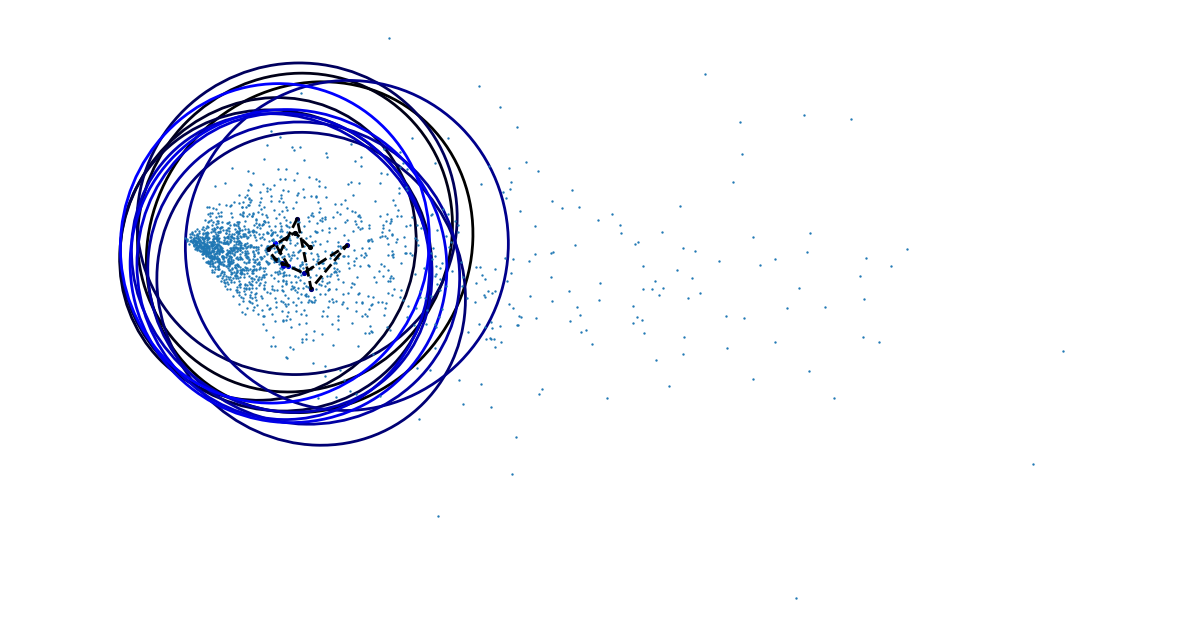

In [44]:
import numpy as np, jax
import jax.numpy as jnp
from numpyro import optim
import models, inference, numpyro
from copy import deepcopy

# --- data to (K, C, N) for the repo’s API ---
Y_all = np.transpose(np.asarray(TEST_RESPONSE), (2, 1, 0))  # (K, C, N)
K, C, N = Y_all.shape
X_all = np.asarray(X_CONDITIONS)

# --- model builders (same as your snippet) ---
gp = models.GaussianProcess(kernel=periodic_kernel_gp, N=N)
wp = models.WishartLRDProcess(kernel=periodic_kernel_wp, P=hyperparams['p'], V=1e-1*jnp.eye(N), optimize_L=False)
lik = models.NormalConditionalLikelihood(N)

from numpyro import handlers

def fit_and_score_trials(train_Y, test_Y, seed=0, n_iter=1000, vi_samples=16, gp_samples=1):
    gp_ = deepcopy(gp); wp_ = deepcopy(wp); lik_ = deepcopy(lik)
    joint = models.JointGaussianWishartProcess(gp_, wp_, lik_)
    varfam = inference.VariationalNormal(joint.model)

    varfam.infer(optim.Adam(1e-1), x=X_all, y=train_Y, n_iter=n_iter, key=jax.random.PRNGKey(seed))
    joint.update_params(varfam.posterior)
    post = models.NormalGaussianWishartPosterior(joint, varfam, X_all)

    # ⬇️ IMPORTANT: seed the sampling used inside log_prob
    with handlers.seed(rng_seed=seed):
        lpp = post.log_prob(X_all, test_Y, vi_samples=vi_samples, gp_samples=gp_samples)

    return float(jnp.mean(lpp)), post

# Leave-one-trial-out (can downsample to K-fold if K is big)
scores = []
for k in range(K):
    train_Y = np.concatenate([Y_all[:k], Y_all[k+1:]], axis=0)  # (K-1, C, N)
    test_Y  = Y_all[k:k+1]                                     # (1, C, N)
    mll, _ = fit_and_score_trials(train_Y, test_Y, seed=2+k)
    scores.append(mll)

print("LOO (trials) mean posterior predictive log-lik:", np.mean(scores))
# 80/20 trial split example
k_split = int(0.8 * K)
mll80, post80 = fit_and_score_trials(Y_all[:k_split], Y_all[k_split:], seed=999)

# ⬇️ Seed the sampling used inside posterior.sample(...)
with handlers.seed(rng_seed=999):
    mu_hat, Sigma_hat, _ = post80.sample(X_all)

visualizations.visualize_pc(
    mu_hat[:, None], Sigma_hat,
    pc=TEST_RESPONSE.reshape(N, C*K).T
)
